In [1]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, AutoETS, AutoTheta, AutoCES)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import yfinance as yf
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1d')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [3]:
# Split data into training and testing sets
Y_train_df = Y_df[Y_df.ds <= '2023-01-01'] # Train set
Y_test_df = Y_df[Y_df.ds > '2023-01-01']   # Test set

In [4]:
season_length = 7 # Define season length as 12 months for monthly data

# Define a list of models for forecasting
models = [
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='D',  # frequency of the data
    n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
)

sf.fit(df=Y_df)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta,CES])

In [5]:
# Generate forecasts for the specified horizon using the sf object
horizon = 90

# Start the timer
start_time = time.time()

# Generate the forecast
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon) 

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Display the elapsed time
print(f"Time taken to generate the forecast: {elapsed_time:.4f} seconds")

# Display the first 5 rows of the forecast
Y_hat_df.head(5)

Time taken to generate the forecast: 3639.8897 seconds


,ds,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,
AAPL,2022-12-31,128.766571,128.900574,128.936859,129.288818
AAPL,2023-01-01,128.608078,128.942734,128.858688,129.301025
AAPL,2023-01-02,128.802933,128.984894,128.852066,128.845840
AAPL,2023-01-03,128.778824,129.027054,128.625076,128.859619
AAPL,2023-01-04,128.393814,129.069214,128.727692,128.911819


In [6]:
Y_hat_df = Y_hat_df.reset_index()

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def evaluate_forecast(y_true, y_pred):
    results = pd.DataFrame({
        'mae': [mean_absolute_error(y_true, y_pred)],
        'mse': [mean_squared_error(y_true, y_pred)],
        'mape': [mean_absolute_percentage_error(y_true, y_pred)],
        'rmse': [np.sqrt(mean_squared_error(y_true, y_pred))],
        'smape:': [symmetric_mean_absolute_percentage_error(y_true, y_pred)],
    })
    return results

# Evaluar múltiples modelos para múltiples tickers
evaluation_results_all_models = {}
models_to_evaluate = ['AutoARIMA', 'AutoETS', 'AutoTheta', 'CES']

for ticker in tickers:
    evaluation_results_all_models[ticker] = {}
    Y_test_true = Y_test_df[Y_test_df['unique_id'] == ticker]['y'].values[:horizon]
    for model in models_to_evaluate:
        Y_test_pred = Y_hat_df.loc[Y_hat_df['unique_id'] == ticker, model].values[:horizon]
        evaluation_results_all_models[ticker][model] = evaluate_forecast(Y_test_true, Y_test_pred)

# Imprimir resultados de evaluación para todos los modelos y tickers
for ticker, models_results in evaluation_results_all_models.items():
    print(f"Results for {ticker}:")
    for model, results in models_results.items():
        print(f"Model: {model}")
        print(results)
        print()

Results for AAPL:
Model: AutoARIMA
         mae         mse      mape       rmse     smape:
0  24.140445  717.948136  0.153035  26.794554  16.843313

Model: AutoETS
         mae         mse      mape       rmse     smape:
0  22.019804  596.291595  0.139627  24.419083  15.228998

Model: AutoTheta
         mae         mse      mape       rmse     smape:
0  23.127007  658.810434  0.146618  25.667303  16.067981

Model: CES
         mae         mse      mape       rmse     smape:
0  22.286607  611.399198  0.141309  24.726488  15.430385

Results for MSFT:
Model: AutoARIMA
         mae          mse      mape       rmse     smape:
0  26.686303  1081.597393  0.095614  32.887648  10.249117

Model: AutoETS
         mae          mse      mape       rmse     smape:
0  29.546519  1312.710238  0.105894  36.231343  11.437559

Model: AutoTheta
         mae          mse      mape       rmse    smape:
0  28.063886  1192.606457  0.100547  34.534135  10.81891

Model: CES
         mae          mse      mape

In [7]:
cv_df = sf.cross_validation(df=Y_train_df, h=90, n_windows=3, step_size=90, level=[99])
cv_df.head(5)

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99,AutoETS,AutoETS-lo-99,AutoETS-hi-99,AutoTheta,AutoTheta-lo-99,AutoTheta-hi-99,CES,CES-lo-99,CES-hi-99
unique_id,,,,,,,,,,,,,,,
AAPL,2021-12-06,2021-12-03,163.023010,158.149750,155.762604,160.536896,159.730911,149.345566,170.116272,159.454727,157.784546,161.158905,160.266281,158.379791,162.248062
AAPL,2021-12-07,2021-12-03,168.801575,156.050797,151.842758,160.258835,159.815903,145.314560,174.317245,159.583115,157.148499,162.173355,160.466309,158.579407,162.447754
AAPL,2021-12-08,2021-12-03,172.647400,154.761108,148.023941,161.498260,159.900909,142.207245,177.594559,159.788681,156.907166,162.706711,160.679443,158.788406,162.665771
AAPL,2021-12-09,2021-12-03,172.134613,153.387939,143.911911,162.863968,159.985901,139.585266,180.386520,159.922180,156.310638,163.712814,160.882553,158.990173,162.869598
AAPL,2021-12-10,2021-12-03,176.956665,151.749603,139.164459,164.334763,160.070892,137.275055,182.866730,159.994583,156.024460,163.474152,161.094177,159.198471,163.085281


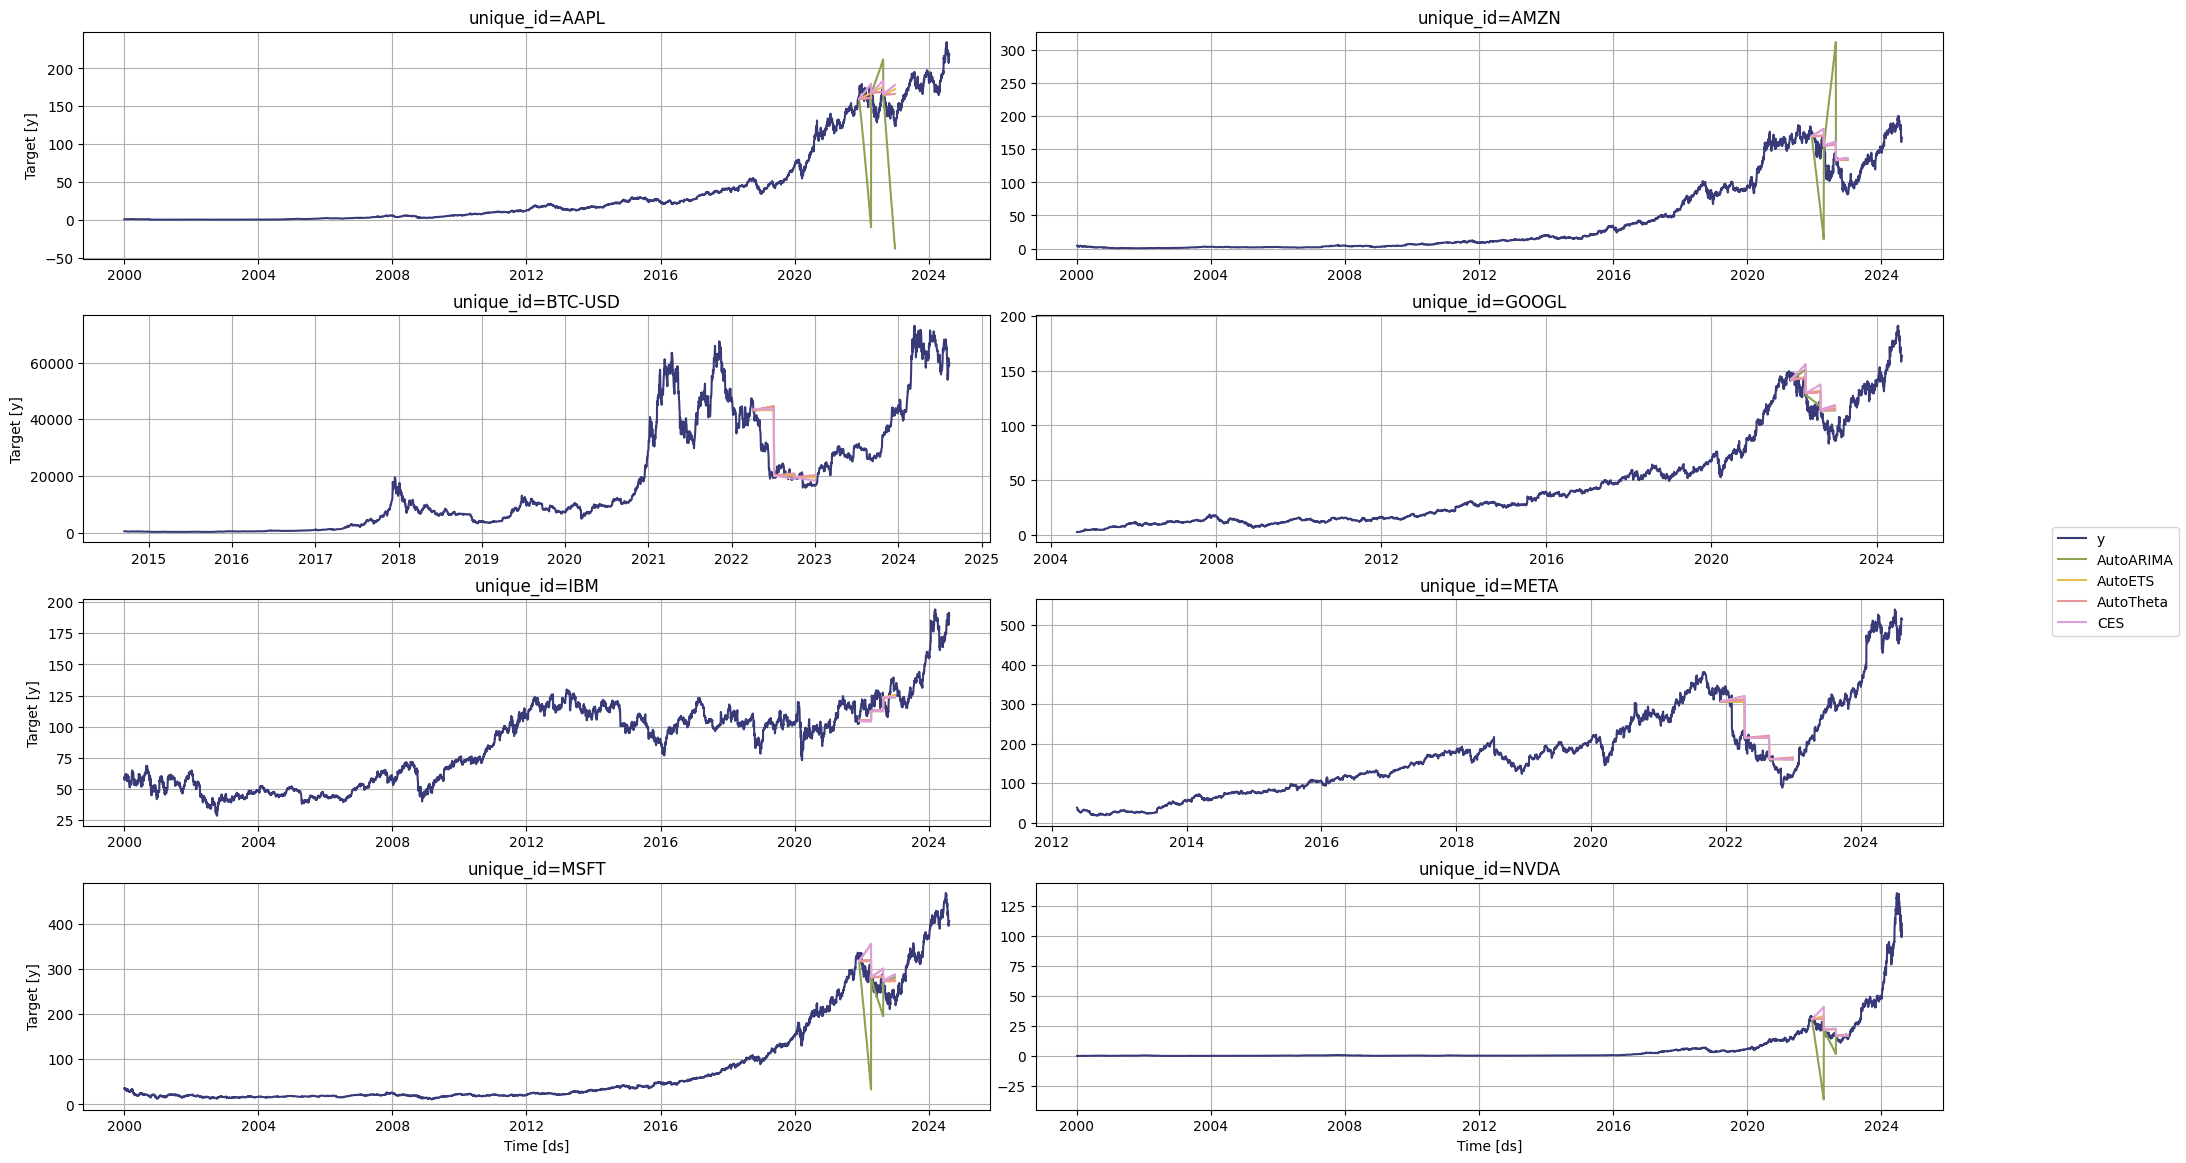

In [8]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))